# Import Library

In [138]:
!pip install category_encoders==2.6.1 ycimpute

In [139]:
import category_encoders
print("category_encoders version:", category_encoders.__version__)

category_encoders version: 2.6.1


In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
#!pip install ycimpute
from ycimpute.imputer import knnimput
from category_encoders import MEstimateEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# Load Dataset

In [141]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [142]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [143]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [144]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [145]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


Observe
Dataset has 14 features and 8693 samples.Transported of these features is target(dependent) variable.
Dataset has object, numeric and bool features. Also it has missing values

In [146]:
df = train_data.copy()

In [147]:
X = df.copy()
y = X.pop("Transported")

In [148]:
X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [149]:
for col_name in X.select_dtypes(["object"]):
    X[col_name], _ = X[col_name].factorize()

In [150]:
X = X.apply(lambda x: x.fillna(x.mean())).astype(int)

In [151]:
features = X.dtypes == int

In [152]:
def MakeMiScore(X, y, disc_features):
    mi_scores = mutual_info_classif(X, y, discrete_features = disc_features)
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores

In [153]:
print(MakeMiScore(X, y, features))

PassengerId     0.693121
Name            0.675740
Cabin           0.542349
FoodCourt       0.156348
Spa             0.145030
RoomService     0.143630
VRDeck          0.134813
ShoppingMall    0.129106
CryoSleep       0.113554
HomePlanet      0.018931
Age             0.015482
Destination     0.006161
VIP             0.000702
Name: MI Scores, dtype: float64


In [154]:
def PlotScores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

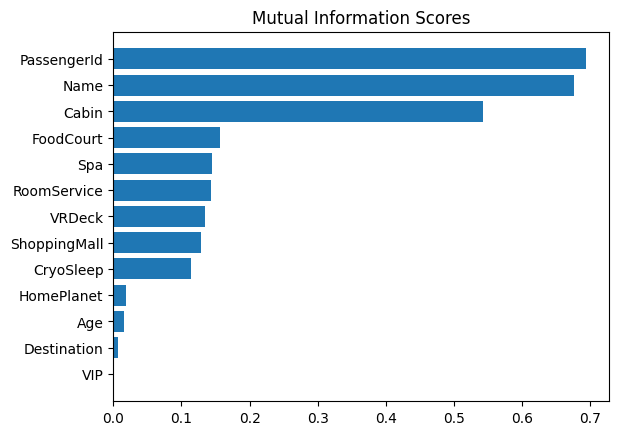

In [155]:
PlotScores(MakeMiScore(X, y, features))

# Data Exploratory 

In [156]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Transported

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


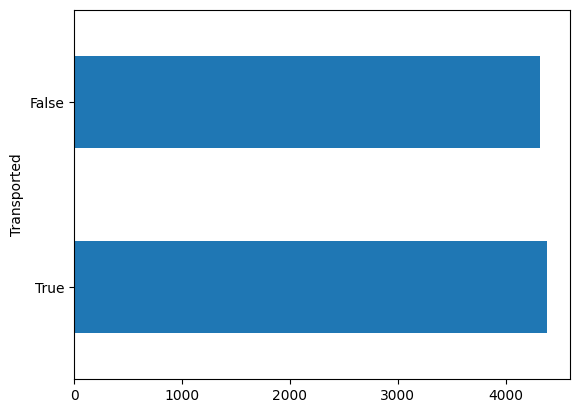

In [157]:
print(train_data.Transported.value_counts(normalize = True))
train_data.Transported.value_counts().plot.barh();

## HomePlanet

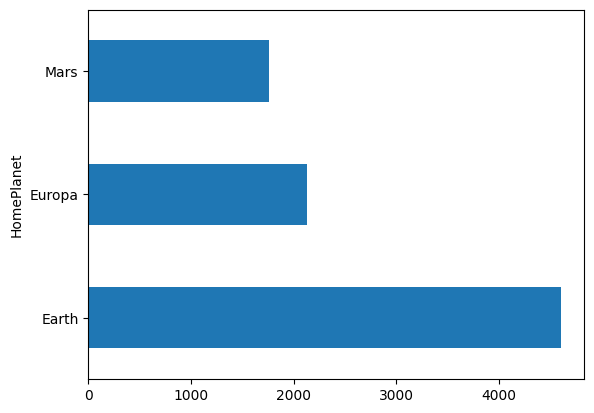

In [158]:
train_data.HomePlanet.value_counts().plot.barh();

HomePlanet  Transported
Earth       False          0.576054
            True           0.423946
Europa      True           0.658846
            False          0.341154
Mars        True           0.523024
            False          0.476976
Name: proportion, dtype: float64


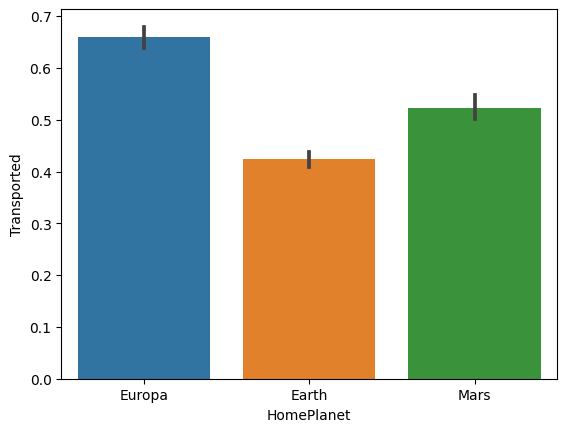

In [159]:
print(train_data.groupby("HomePlanet")["Transported"].value_counts(normalize=True))
sns.barplot(x = "HomePlanet", y= "Transported", data = df);

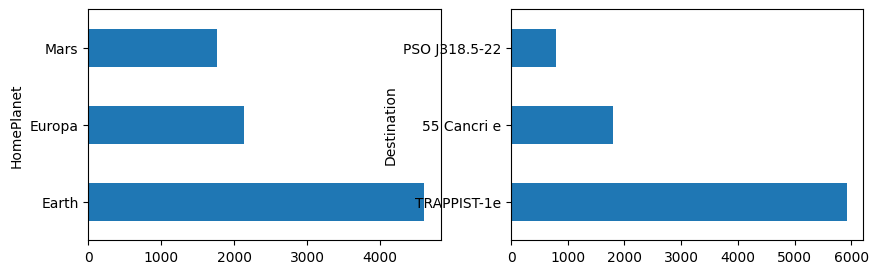

In [160]:
plt.figure(figsize=(10,3))
plt.subplot(121)
train_data["HomePlanet"].value_counts().plot.barh()
plt.subplot(122)
train_data["Destination"].value_counts().plot.barh()
plt.show()

In [161]:
train_data.groupby("HomePlanet")["Destination"].value_counts(normalize=True)

HomePlanet  Destination  
Earth       TRAPPIST-1e      0.688652
            PSO J318.5-22    0.158117
            55 Cancri e      0.153231
Europa      TRAPPIST-1e      0.567813
            55 Cancri e      0.423114
            PSO J318.5-22    0.009074
Mars        TRAPPIST-1e      0.859056
            55 Cancri e      0.112405
            PSO J318.5-22    0.028538
Name: proportion, dtype: float64

HomePlanet  VIP  
Earth       False    1.000000
Europa      False    0.937291
            True     0.062709
Mars        False    0.963287
            True     0.036713
Name: proportion, dtype: float64


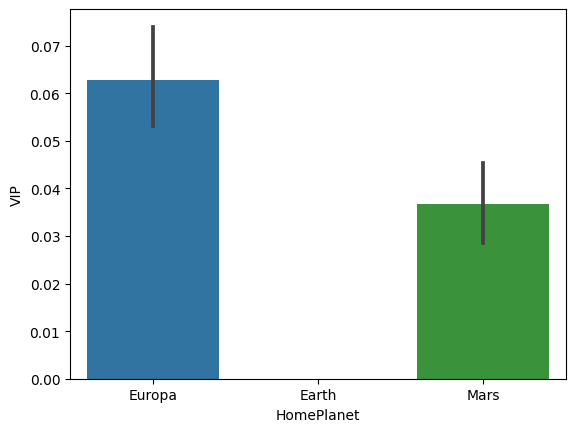

In [162]:
print(train_data.groupby("HomePlanet")["VIP"].value_counts(normalize=True))
sns.barplot(train_data, x ="HomePlanet",y = "VIP");

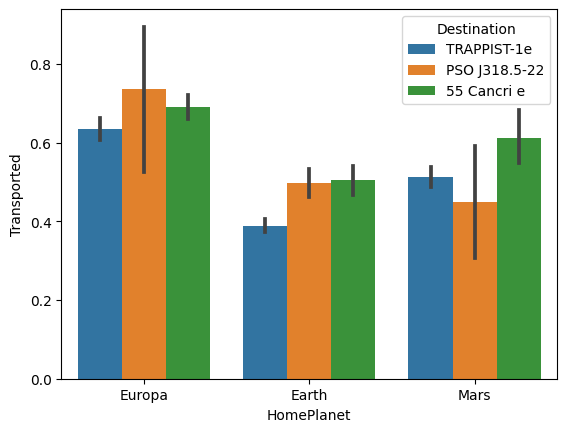

In [163]:
sns.barplot(x = "HomePlanet", y= "Transported", data = train_data, hue = "Destination");

Observe

Ratio of Transported passengers and untransported passengers almost same.
Passengers whose Homeplanet is Earth more after Europa and Mars respectively.
Homeplanet is effective in Transported. Passengers in Europa are more transported others.
There aren't VIP passenger in Earth

## CryoSleep

CryoSleep
False    0.641694
True     0.358306
Name: proportion, dtype: float64


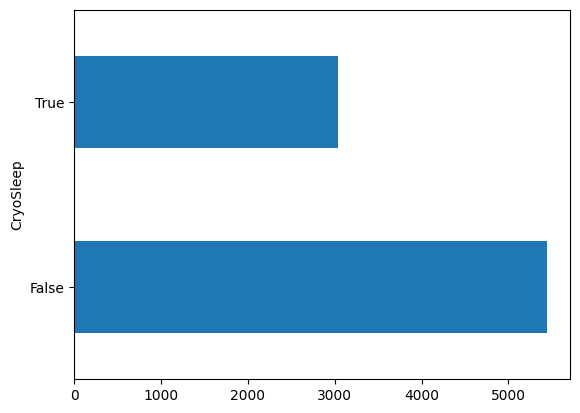

In [164]:
print(train_data["CryoSleep"].value_counts(normalize = True))
train_data["CryoSleep"].value_counts().plot.barh();

In [165]:
print(train_data.groupby("CryoSleep")["VIP"].value_counts(normalize = True))

CryoSleep  VIP  
False      False    0.967093
           True     0.032907
True       False    0.992910
           True     0.007090
Name: proportion, dtype: float64


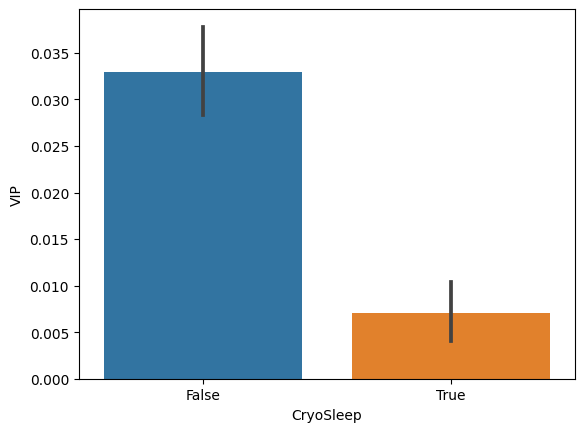

In [166]:
sns.barplot(x= "CryoSleep", y= "VIP", data = train_data);

CryoSleep  Transported
False      False          0.671079
           True           0.328921
True       True           0.817583
           False          0.182417
Name: proportion, dtype: float64


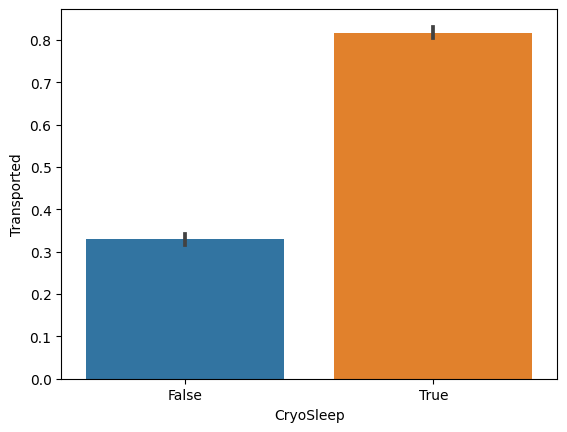

In [167]:
print(train_data.groupby("CryoSleep")["Transported"].value_counts(normalize = True))
sns.barplot(x = "CryoSleep", y= "Transported", data = train_data);

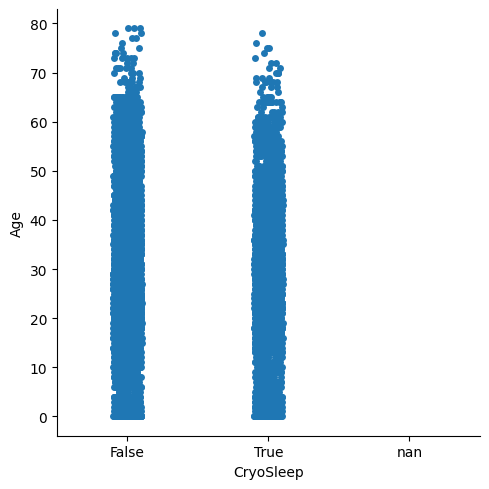

In [168]:
sns.catplot(x = "CryoSleep",y= "Age", data = train_data);

In [169]:
train_data.groupby("CryoSleep")[["Spa", "VRDeck", "ShoppingMall", "RoomService", "FoodCourt"]].aggregate(["min", "max"])

Spa          VRDeck          ShoppingMall          RoomService  \
           min      max    min      max          min      max         min   
CryoSleep                                                                   
False      0.0  22408.0    0.0  24133.0          0.0  23492.0         0.0   
True       0.0      0.0    0.0      0.0          0.0      0.0         0.0   

                   FoodCourt           
               max       min      max  
CryoSleep                              
False      14327.0       0.0  29813.0  
True           0.0       0.0      0.0

In [170]:
train_data.groupby("CryoSleep")["HomePlanet"].value_counts(normalize = True)

CryoSleep  HomePlanet
False      Earth         0.584384
           Europa        0.218627
           Mars          0.196990
True       Earth         0.466577
           Europa        0.307562
           Mars          0.225861
Name: proportion, dtype: float64

In [171]:
train_data.groupby("CryoSleep")["Destination"].value_counts(normalize = True)

CryoSleep  Destination  
False      TRAPPIST-1e      0.734225
           55 Cancri e      0.191561
           PSO J318.5-22    0.074214
True       TRAPPIST-1e      0.624624
           55 Cancri e      0.247240
           PSO J318.5-22    0.128137
Name: proportion, dtype: float64

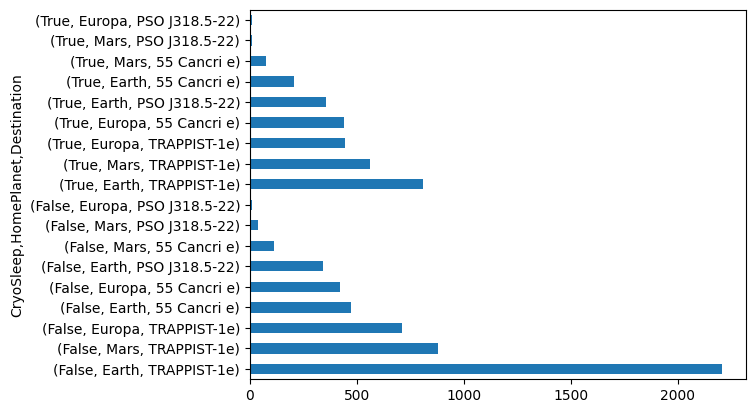

In [172]:
train_data.groupby("CryoSleep")[["HomePlanet", "Destination"]].value_counts().plot.barh();

## Destination

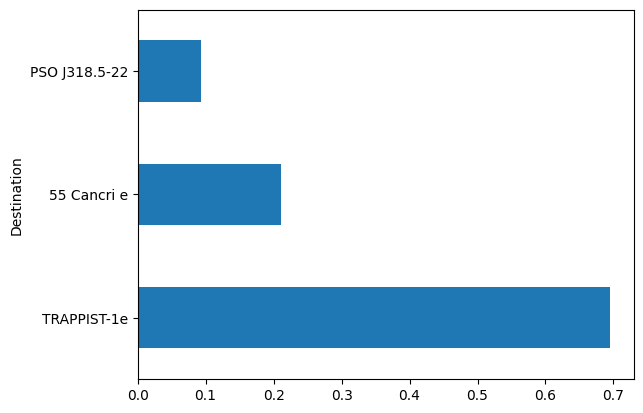

In [173]:
train_data["Destination"].value_counts(normalize = True).plot.barh();

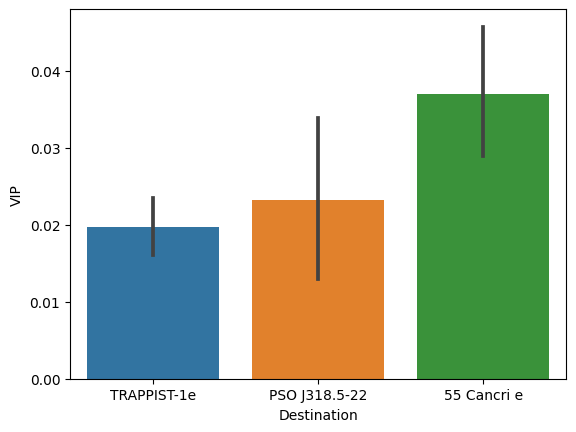

In [174]:
sns.barplot(x = "Destination", y= "VIP", data = train_data);

In [175]:
print(train_data.groupby("Destination")["VIP"].value_counts(normalize=True))

Destination    VIP  
55 Cancri e    False    0.963005
               True     0.036995
PSO J318.5-22  False    0.976744
               True     0.023256
TRAPPIST-1e    False    0.980280
               True     0.019720
Name: proportion, dtype: float64


Destination    Transported
55 Cancri e    True           0.610000
               False          0.390000
PSO J318.5-22  True           0.503769
               False          0.496231
TRAPPIST-1e    False          0.528825
               True           0.471175
Name: proportion, dtype: float64


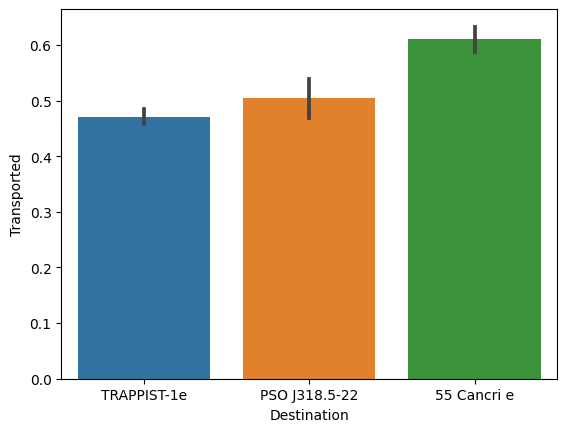

In [176]:
print(train_data.groupby("Destination")["Transported"].value_counts(normalize = True))
sns.barplot(x = "Destination", y= "Transported", data=train_data);

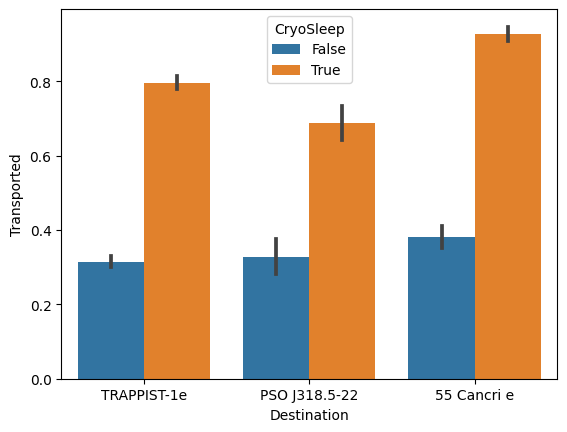

In [177]:
sns.barplot(x = "Destination", y= "Transported", hue = "CryoSleep",data=train_data);

Observe
Situation of VIP is not effective Destination
Those with destination 55 Cancri-e are relatively more likely to be reached than others. This reason for this situation 55 cancri-e passengers may have relatively high sleeping rate.

## Age

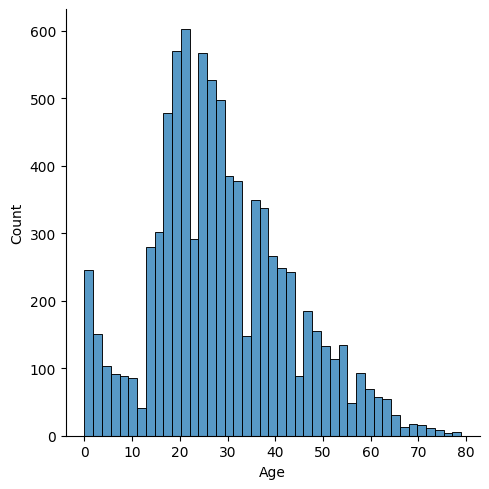

In [178]:
sns.displot(train_data["Age"]);

<Axes: xlabel='Age', ylabel='RoomService'>

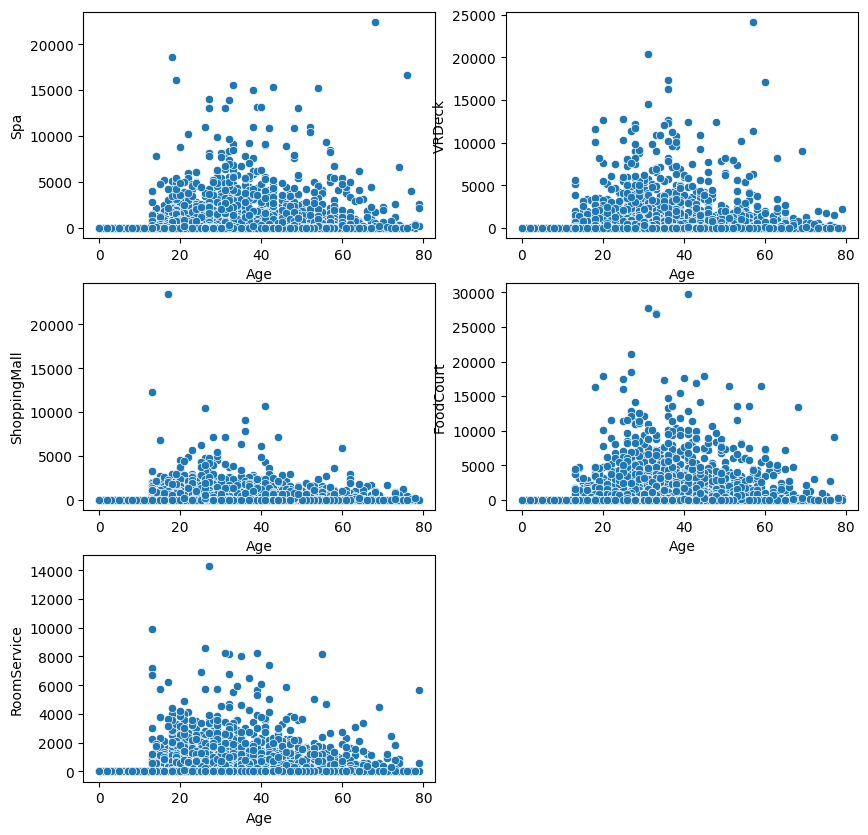

In [179]:
plt.figure(figsize = (10,10))
plt.subplot(321)
sns.scatterplot(x = "Age", y = "Spa", data = train_data) 
plt.subplot(322)
sns.scatterplot(x = "Age", y = "VRDeck", data = train_data)
plt.subplot(323)
sns.scatterplot(x = "Age", y = "ShoppingMall", data = train_data)
plt.subplot(324)
sns.scatterplot(x = "Age", y = "FoodCourt", data = train_data)
plt.subplot(325)
sns.scatterplot(x = "Age", y = "RoomService", data = train_data)

In [180]:
print(train_data[train_data["Spa"]>0]["Age"].min())
print(train_data[train_data["VRDeck"]>0]["Age"].min())
print(train_data[train_data["FoodCourt"]>0]["Age"].min())
print(train_data[train_data["RoomService"]>0]["Age"].min())
print(train_data[train_data["ShoppingMall"]>0]["Age"].min())

13.0
13.0
13.0
13.0
13.0


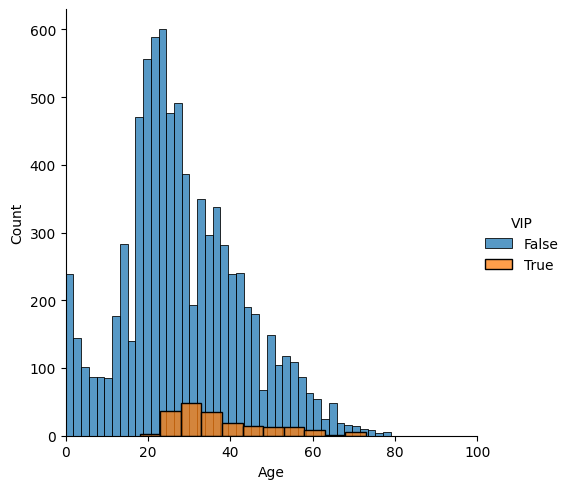

In [181]:
(sns.FacetGrid(train_data, hue = "VIP", height=5,xlim=(0,100)).map(sns.histplot, "Age")).add_legend();

In [182]:
train_data.groupby("VIP")["Age"].agg(["min", "max"])

,min,max
VIP,,
False,0.0,79.0
True,18.0,73.0


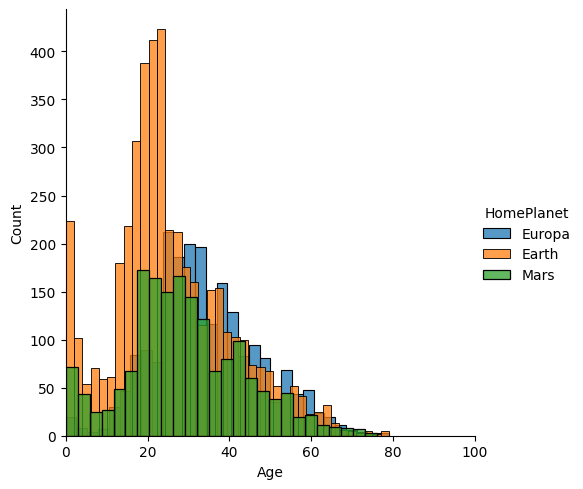

In [183]:
(sns.FacetGrid(train_data, hue = "HomePlanet", height=5,xlim=(0,100)).map(sns.histplot, "Age")).add_legend();

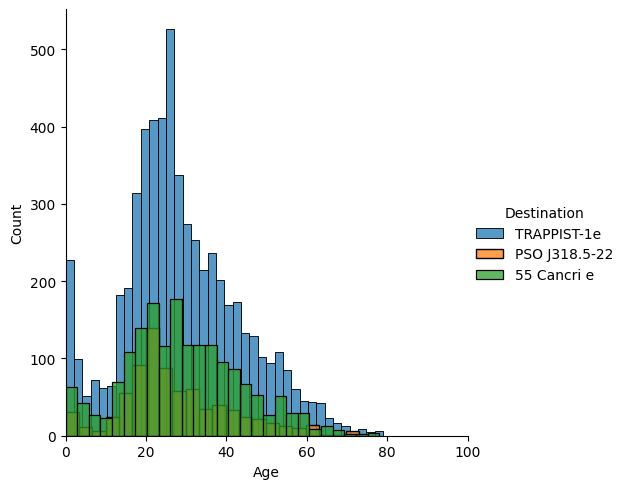

In [184]:
(sns
.FacetGrid(train_data, hue = "Destination", height=5,xlim=(0,100))
.map(sns.histplot, "Age")).add_legend();

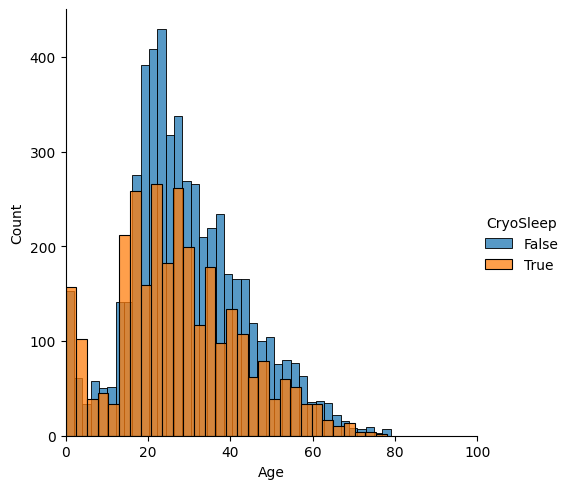

In [185]:
(sns
.FacetGrid(train_data, hue = "CryoSleep", height=5,xlim=(0,100))
.map(sns.histplot, "Age")).add_legend();

Observe
Passengers under 13 years of age do not have any spend
There aren't any VIP passengers under 18 years age

 ## VIP

VIP
False    0.976561
True     0.023439
Name: proportion, dtype: float64


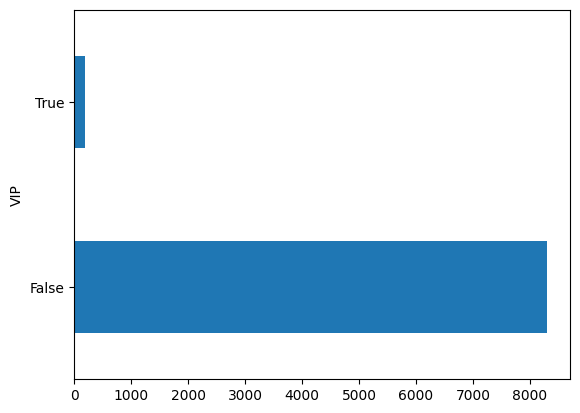

In [186]:
print(train_data.VIP.value_counts(normalize=True))
train_data.VIP.value_counts().plot.barh();

VIP    Transported
False  True           0.506332
       False          0.493668
True   False          0.618090
       True           0.381910
Name: proportion, dtype: float64


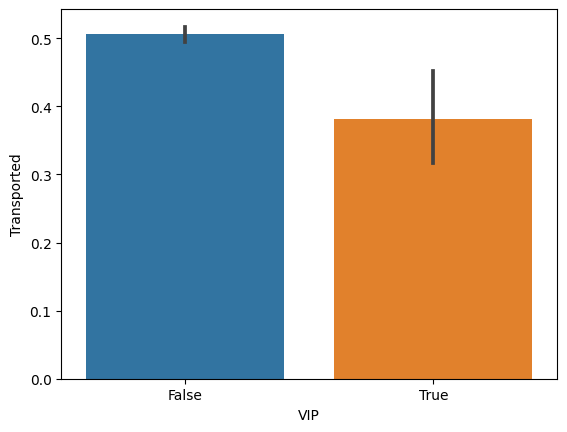

In [187]:
print(train_data.groupby("VIP")["Transported"].value_counts(normalize = True))
sns.barplot(x = "VIP", y= "Transported", data = train_data);

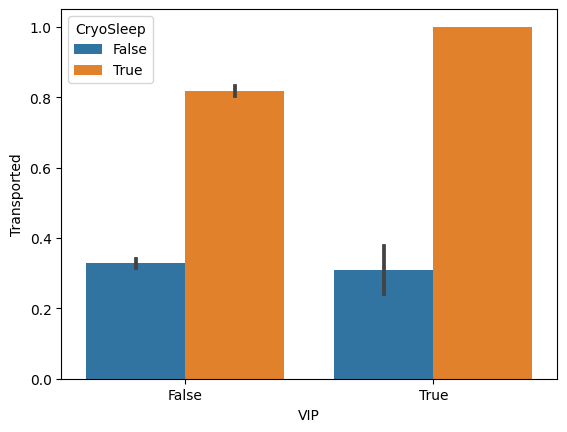

In [188]:
sns.barplot(x = "VIP", y= "Transported", hue = "CryoSleep",data = train_data);

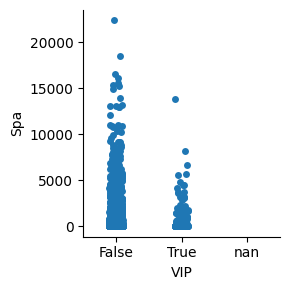

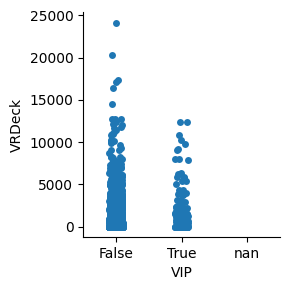

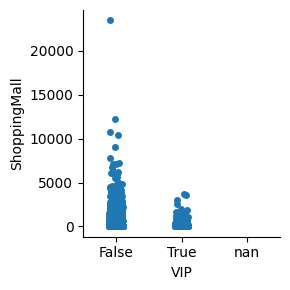

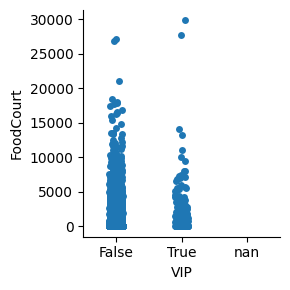

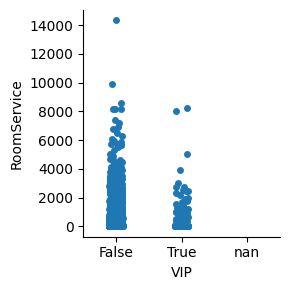

In [189]:
sns.catplot(x = "VIP", y = "Spa", data = train_data,height=3) 
plt.show()
sns.catplot(x = "VIP", y = "VRDeck", data = train_data,height=3)
plt.show()
sns.catplot(x = "VIP", y = "ShoppingMall", data = train_data,height=3)
plt.show()
sns.catplot(x = "VIP", y = "FoodCourt", data = train_data,height=3)
plt.show()
sns.catplot(x = "VIP", y = "RoomService", data = train_data,height=3)
plt.show()

Destination    VIP  
55 Cancri e    False    1692
               True       65
PSO J318.5-22  False     756
               True       18
TRAPPIST-1e    False    5667
               True      114
Name: count, dtype: int64


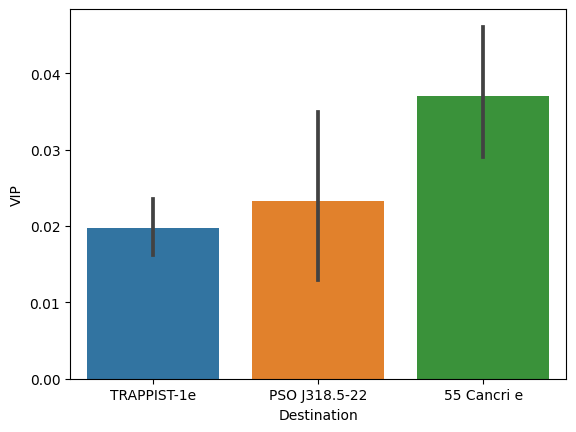

In [190]:
print(train_data.groupby("Destination")["VIP"].value_counts())
sns.barplot(x = "Destination", y= "VIP", data = train_data);

HomePlanet  VIP  
Earth       False    4487
Europa      False    1958
            True      131
Mars        False    1653
            True       63
Name: count, dtype: int64


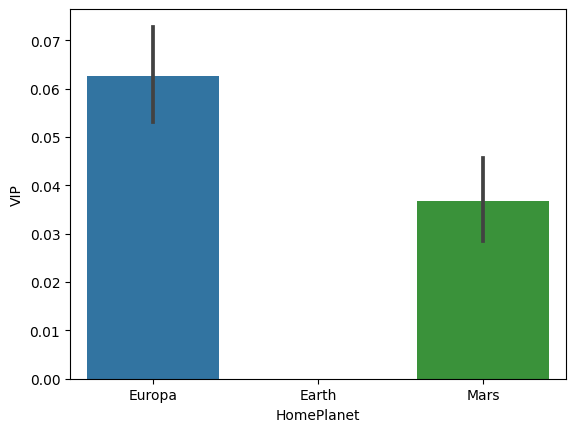

In [191]:
print(train_data.groupby("HomePlanet")["VIP"].value_counts())
sns.barplot(x = "HomePlanet", y= "VIP", data = train_data);

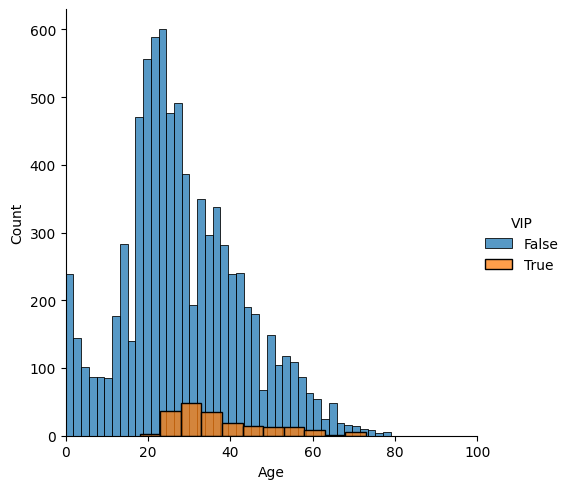

In [192]:
(sns
.FacetGrid(train_data, hue = "VIP", height=5,xlim=(0,100))
.map(sns.histplot, "Age")).add_legend();

Observe
Passengers of VIP percent 2 in all passengers.
Transported rate of not VIP passengers are higher
Higher spend for non-VIP travellers, excluding foodcourt
There aren't VIP passenger in Earth and There aren't any VIP passengers under 18 years age

# Feature Engineering and Missing Values

## Transported

In [193]:
# First check missing values
train_data["Transported"].isnull().values.any()

False

In [194]:
# Transported convert into 1-0 with check
print(train_data["Transported"].value_counts())
train_data["Transported"] = [1 if i == True else 0 for i in train_data["Transported"]]
print(train_data["Transported"].value_counts())

Transported
True     4378
False    4315
Name: count, dtype: int64
Transported
1    4378
0    4315
Name: count, dtype: int64


In [195]:
# And we can merge train and test data for feature engineering and missing values
#AllData = pd.concat([train_data, test_data], ignore_index=True)

In [196]:
#AllData

## VIP

In [197]:
# There aren't VIP passenger in Earth and There aren't any VIP passengers under 18 years age.
# Some of the missing values can be filled according to this determination
print(train_data["VIP"].isnull().sum())
print(test_data["VIP"].isnull().sum())

203
93


In [198]:
AgeVIPIndex = train_data[(train_data["VIP"].isnull() == True) & (train_data["Age"]<18)][["VIP"]].index
AgeVIPIndex_test = test_data[(test_data["VIP"].isnull() == True) & (test_data["Age"]<18)][["VIP"]].index

In [199]:
train_data["VIP"][AgeVIPIndex] = False
test_data["VIP"][AgeVIPIndex_test] = False

In [200]:
EarthVIPIndex = train_data[(train_data["VIP"].isnull() == True) & (train_data["HomePlanet"]=="Earth")][["VIP"]].index
EarthVIPIndex_test = test_data[(test_data["VIP"].isnull() == True) & (test_data["HomePlanet"]=="Earth")][["VIP"]].index

In [201]:
train_data["VIP"][EarthVIPIndex] = False
test_data["VIP"][EarthVIPIndex_test] = False

In [202]:
print(train_data["VIP"].isnull().sum())
print(test_data["VIP"].isnull().sum())

76
49


## Spending

In [203]:
# Passengers under 13 years of age  and sleeping passengers don't have any spend
#  Some of the missing values can be filled according to this determination
print(train_data["Spa"].isnull().sum())
print(train_data["VRDeck"].isnull().sum())
print(train_data["ShoppingMall"].isnull().sum())
print(train_data["FoodCourt"].isnull().sum())
print(train_data["RoomService"].isnull().sum())

183
188
208
183
181


In [204]:
#Define func for filling of missing values
def FillSpend(dataset, feature):
    spend_index = dataset[
        (dataset[feature].isnull() == True) &
        ((dataset["Age"]<13) | (dataset["CryoSleep"] == True))
    ].index
    dataset[feature][spend_index] = 0

def FillSpend_test(dataset, feature):
    spend_index = dataset[
        (dataset[feature].isnull() == True) &
        ((dataset["Age"]<13) | (dataset["CryoSleep"] == True))
    ].index
    dataset[feature][spend_index] = 0

In [205]:
spend_list = ["Spa", "RoomService", "FoodCourt", "VRDeck", "ShoppingMall"]
for i in spend_list:
    FillSpend(train_data, i)

spend_list_test = ["Spa", "RoomService", "FoodCourt", "VRDeck", "ShoppingMall"]
for i in spend_list_test:
    FillSpend_test(test_data, i)

In [206]:
#check
#print(AllData["Spa"].isnull().sum())
#print(AllData["VRDeck"].isnull().sum())
#print(AllData["ShoppingMall"].isnull().sum())
#print(AllData["FoodCourt"].isnull().sum())
#print(AllData["RoomService"].isnull().sum())

## Name and Passenger Id

In [207]:
# We can split of name as name and surname after can remove name
# Also missing values of name can be filled group_ıd

In [208]:
train_data["GroupId"] = train_data.PassengerId.str.split("_", expand = True)[0].astype(int)
train_data["GroupNumber"] = train_data.PassengerId.str.split("_", expand = True)[1].astype(int)

test_data["GroupId"] = test_data.PassengerId.str.split("_", expand = True)[0].astype(int)
test_data["GroupNumber"] = test_data.PassengerId.str.split("_", expand = True)[1].astype(int)

In [209]:
train_data.drop(["PassengerId"], axis = 1, inplace = True)
test_data.drop(["PassengerId"], axis = 1, inplace = True)

In [210]:
train_data["Surname"] = train_data["Name"].str.split(" ", expand = True)[1]
test_data["Surname"] = test_data["Name"].str.split(" ", expand = True)[1]

In [211]:
train_data.drop(["Name"], axis = 1, inplace = True)
test_data.drop(["Name"], axis = 1, inplace = True)

In [212]:
# Those with group number greater than 1 have the same group id number. 
#Therefore, considering that they are the same family their surnames can be filled in according to the previous sample. 
SurnameIndex = train_data[(train_data["GroupNumber"]>1) & (train_data["Surname"].isnull() == True)].index
SurnameIndex_test = test_data[(test_data["GroupNumber"]>1) & (test_data["Surname"].isnull() == True)].index

In [213]:
for i in SurnameIndex:
    train_data["Surname"][i] = train_data["Surname"][i-1]

for i in SurnameIndex_test:
    test_data["Surname"][i] = test_data["Surname"][i-1]

## CryoSleep

In [214]:
train_data[train_data["CryoSleep"].isnull() == True]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,GroupNumber,Surname
92,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,1,99,2,Connelson
98,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,0,105,1,Cleachrand
104,Europa,NaN,B/5/P,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,0.0,1687.0,0,110,2,Bootious
111,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,1,115,1,Pead
152,Earth,NaN,E/11/S,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,5.0,0.0,1,173,1,Grifford
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8620,Europa,NaN,C/308/P,55 Cancri e,44.0,False,0.0,0.0,0.0,0.0,0.0,1,9197,1,Platch
8651,Earth,NaN,G/1498/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,0.0,0,9227,5,Hinglendez
8664,Earth,NaN,G/1490/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,1,9246,1,NaN
8675,Earth,NaN,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,11.0,NaN,1,9259,1,Gilleyons


In [215]:
# Those who make any spending are not asleep.Therefore missing values can be filled this situation

In [216]:
SleepIndex = train_data[
    (train_data["CryoSleep"].isnull() == True) & 
    (
        (train_data["Spa"]>0) | (train_data["RoomService"]>0)
        | (train_data["FoodCourt"]>0) | (train_data["VRDeck"]>0) | (train_data["ShoppingMall"]>0)
    )
].index

SleepIndex_test = test_data[
    (test_data["CryoSleep"].isnull() == True) & 
    (
        (test_data["Spa"]>0) | (test_data["RoomService"]>0)
        | (test_data["FoodCourt"]>0) | (test_data["VRDeck"]>0) | (test_data["ShoppingMall"]>0)
    )
].index

In [217]:
train_data["CryoSleep"][SleepIndex] = False
test_data["CryoSleep"][SleepIndex_test] = False

## HomePlanet / Destination

In [218]:
# Those with group number greater than 1 have the same group id number. 
#Therefore, considering that they are the same family their HomePlanet and Destination can be filled in according to the previous sample.

In [219]:
HPIndex=train_data[(train_data["GroupNumber"]>1) & (train_data["HomePlanet"].isnull() == True)].index
DestIndex = train_data[(train_data["GroupNumber"]>1) & (train_data["Destination"].isnull() == True)].index

HPIndex_test =test_data[(test_data["GroupNumber"]>1) & (test_data["HomePlanet"].isnull() == True)].index
DestIndex_test = test_data[(test_data["GroupNumber"]>1) & (test_data["Destination"].isnull() == True)].index

In [220]:
for i in HPIndex:
    train_data["HomePlanet"][i] = train_data["HomePlanet"][i-1]
for i in DestIndex:
    train_data["Destination"][i] = train_data["Destination"][i-1]

for i in HPIndex_test:
    test_data["HomePlanet"][i] = test_data["HomePlanet"][i-1]
for i in DestIndex_test:
    test_data["Destination"][i] = test_data["Destination"][i-1]

## Cabin

In [221]:
# We can split Cabin Deck and Side
train_data["CabinDeck"] = train_data.Cabin.str.split("/", expand = True)[0]
train_data["CabinSide"] = train_data.Cabin.str.split("/", expand = True)[2]

# We can split Cabin Deck and Side
test_data["CabinDeck"] = test_data.Cabin.str.split("/", expand = True)[0]
test_data["CabinSide"] = test_data.Cabin.str.split("/", expand = True)[2]

In [222]:
train_data.drop(["Cabin"],axis = 1, inplace = True)
test_data.drop(["Cabin"],axis = 1, inplace = True)

In [223]:
train_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,1,1,Ofracculy,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,2,1,Vines,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,3,1,Susent,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,3,2,Susent,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,4,1,Santantines,F,S


In [224]:
test_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,13,1,Carsoning,G,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,18,1,Peckers,F,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,19,1,Unhearfus,C,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,21,1,Caltilter,C,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,23,1,Harperez,F,S


In [225]:
# Those with group number greater than 1 have the same group id number. 
#Therefore, considering that they are the same family their CabinDeck and CabinSide can be filled in according to the previous sample.

In [226]:
DecIndex = train_data[(train_data["GroupNumber"]>1) & (train_data["CabinDeck"].isnull() == True)].index
SideIndex = train_data[(train_data["GroupNumber"]>1) & (train_data["CabinSide"].isnull() == True)].index

DecIndex_test = test_data[(test_data["GroupNumber"]>1) & (test_data["CabinDeck"].isnull() == True)].index
SideIndex_test = test_data[(test_data["GroupNumber"]>1) & (test_data["CabinSide"].isnull() == True)].index

In [227]:
for i in DecIndex:
    train_data["CabinDeck"][i] = train_data["CabinDeck"][i-1]
for i in SideIndex:
    train_data["CabinSide"][i] = train_data["CabinSide"][i-1]

for i in DecIndex_test:
    test_data["CabinDeck"][i] = test_data["CabinDeck"][i-1]
for i in SideIndex_test:
    test_data["CabinSide"][i] = test_data["CabinSide"][i-1]

In [228]:
train_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,1,1,Ofracculy,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,2,1,Vines,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,3,1,Susent,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,3,2,Susent,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,4,1,Santantines,F,S


In [229]:
test_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,13,1,Carsoning,G,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,18,1,Peckers,F,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,19,1,Unhearfus,C,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,21,1,Caltilter,C,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,23,1,Harperez,F,S


## Convert Categorical

In [230]:
y = train_data.pop("Transported")

In [231]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8551 non-null   object 
 1   CryoSleep     8595 non-null   object 
 2   Destination   8561 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8617 non-null   object 
 5   RoomService   8586 non-null   float64
 6   FoodCourt     8587 non-null   float64
 7   ShoppingMall  8590 non-null   float64
 8   Spa           8579 non-null   float64
 9   VRDeck        8586 non-null   float64
 10  GroupId       8693 non-null   int64  
 11  GroupNumber   8693 non-null   int64  
 12  Surname       8558 non-null   object 
 13  CabinDeck     8559 non-null   object 
 14  CabinSide     8559 non-null   object 
dtypes: float64(6), int64(2), object(7)
memory usage: 1018.8+ KB


In [232]:
#Label Encoder
EncFeatures = [train_data.select_dtypes(["object"]).columns]

lbe = OrdinalEncoder()
for feature in EncFeatures:
    train_data[feature]= lbe.fit_transform(train_data[feature])

EncFeatures_test = [test_data.select_dtypes(["object"]).columns]

lbe_test = OrdinalEncoder()
for feature in EncFeatures_test:
    test_data[feature]= lbe_test.fit_transform(test_data[feature])

In [233]:
train_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1431.0,1.0,0.0
1,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,2,1,2109.0,5.0,1.0
2,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,3,1,1990.0,0.0,1.0
3,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,3,2,1990.0,0.0,1.0
4,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,4,1,1778.0,5.0,1.0


In [234]:
test_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,0.0,1.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,13,1,275.0,6.0,1.0
1,0.0,0.0,2.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,18,1,1190.0,5.0,1.0
2,1.0,1.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,19,1,1604.0,2.0,1.0
3,1.0,0.0,2.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,21,1,262.0,2.0,1.0
4,0.0,0.0,2.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,23,1,736.0,5.0,1.0


## Remaining Missing Value with KNN

In [235]:
# Even if some missing samples have been filled in the above operations.
# there are still missing samples. For others, predictive value assignment can be used

In [236]:
var_names = list(train_data)
n_df = np.array(train_data)
dff = knnimput.KNN(k = 4).complete(n_df)

var_names_test = list(test_data)
n_df_test = np.array(test_data)
dff_test = knnimput.KNN(k = 4).complete(n_df_test)

Imputing row 1/8693 with 0 missing, elapsed time: 12.640
Imputing row 101/8693 with 0 missing, elapsed time: 12.642
Imputing row 201/8693 with 0 missing, elapsed time: 12.642
Imputing row 301/8693 with 0 missing, elapsed time: 12.644
Imputing row 401/8693 with 0 missing, elapsed time: 12.645
Imputing row 501/8693 with 0 missing, elapsed time: 12.646
Imputing row 601/8693 with 0 missing, elapsed time: 12.647
Imputing row 701/8693 with 0 missing, elapsed time: 12.647
Imputing row 801/8693 with 0 missing, elapsed time: 12.648
Imputing row 901/8693 with 0 missing, elapsed time: 12.649
Imputing row 1001/8693 with 0 missing, elapsed time: 12.651
Imputing row 1101/8693 with 0 missing, elapsed time: 12.651
Imputing row 1201/8693 with 0 missing, elapsed time: 12.652
Imputing row 1301/8693 with 1 missing, elapsed time: 12.653
Imputing row 1401/8693 with 0 missing, elapsed time: 12.654
Imputing row 1501/8693 with 0 missing, elapsed time: 12.655
Imputing row 1601/8693 with 1 missing, elapsed time:

In [237]:
train_data = pd.DataFrame(dff, columns=var_names)
test_data = pd.DataFrame(dff_test, columns=var_names_test)

In [238]:
#check
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

False
False


In [239]:
train_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1431.0,1.0,0.0
1,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,2.0,1.0,2109.0,5.0,1.0
2,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,3.0,1.0,1990.0,0.0,1.0
3,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,3.0,2.0,1990.0,0.0,1.0
4,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,4.0,1.0,1778.0,5.0,1.0


In [240]:
test_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,0.0,1.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0,275.0,6.0,1.0
1,0.0,0.0,2.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,18.0,1.0,1190.0,5.0,1.0
2,1.0,1.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,1.0,1604.0,2.0,1.0
3,1.0,0.0,2.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,21.0,1.0,262.0,2.0,1.0
4,0.0,0.0,2.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,23.0,1.0,736.0,5.0,1.0


## MEstimate Encoder

In [241]:
# Some categorical variables are multicategorical, so it's appropriate to use MEstimator

In [242]:
#print(train_data["GroupId"].nunique())
#print(train_data["GroupNumber"].nunique())
#print(train_data["Surname"].nunique())
#print(train_data["CabinDeck"].nunique())

In [243]:
#encoders = MEstimateEncoder(cols = ["GroupId", "GroupNumber", "Surname", "CabinDeck"], m=4.0)
#encoders.fit(train_data, y)

In [244]:
#AllData = encoders.transform(train_data)

In [245]:
#print(train_data["GroupId"].nunique())
#print(train_data["GroupNumber"].nunique())
#print(train_data["Surname"].nunique())
#print(train_data["CabinDeck"].nunique())

## Outlier Samples and Normalize

In [246]:
#The variance of variables outlier samples will be selected with LocalOutlierFactor

In [247]:
clf = LocalOutlierFactor(n_neighbors=5)
clf.fit_predict(train_data)

clf_test = LocalOutlierFactor(n_neighbors=5)
clf_test.fit_predict(test_data)

array([1, 1, 1, ..., 1, 1, 1])

In [248]:
clf_scores = clf.negative_outlier_factor_
clf_scores_test = clf_test.negative_outlier_factor_

In [249]:
np.sort(clf_scores)[0:40]
np.sort(clf_scores_test)[0:40]

array([-7.00773343, -5.93404104, -5.69389462, -5.17399743, -5.06734609,
       -4.92259044, -4.7845645 , -4.75768938, -4.58076797, -4.39398369,
       -4.29026144, -4.14427313, -4.10712739, -4.04854096, -4.01152381,
       -3.96115921, -3.91571746, -3.82399421, -3.80879796, -3.79014253,
       -3.7747184 , -3.71601005, -3.67277823, -3.63521751, -3.61713088,
       -3.55190409, -3.5274946 , -3.50141772, -3.41143038, -3.38058055,
       -3.32659442, -3.27969125, -3.22645173, -3.21801481, -3.11795386,
       -3.10254063, -3.0473025 , -2.99777451, -2.99621015, -2.99515656])

In [250]:
threshold_value = np.sort(clf_scores)[18]
threshold_value_test = np.sort(clf_scores_test)[18]

In [251]:
outlier_samples = train_data[clf_scores<threshold_value].to_records(index = False)
outlier_samples_test = test_data[clf_scores_test<threshold_value_test].to_records(index = False)

In [252]:
outlier_samples[:] = train_data[clf_scores == threshold_value].to_records(index = False)
outlier_samples_test[:] = test_data[clf_scores_test == threshold_value_test].to_records(index = False)

In [253]:
train_data[clf_scores<threshold_value] = pd.DataFrame(outlier_samples, index = train_data[clf_scores<threshold_value].index)
test_data[clf_scores_test<threshold_value_test] = pd.DataFrame(outlier_samples_test, index = test_data[clf_scores_test<threshold_value_test].index)

In [254]:
#check
train_data[clf_scores<threshold_value]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
191,0.0,0.0,0.0,41.0,0.0,312.0,89.0,44.0,0.0,252.0,3842.0,1.0,2111.0,5.0,0.0
550,0.0,0.0,0.0,41.0,0.0,312.0,89.0,44.0,0.0,252.0,3842.0,1.0,2111.0,5.0,0.0
1138,0.0,0.0,0.0,41.0,0.0,312.0,89.0,44.0,0.0,252.0,3842.0,1.0,2111.0,5.0,0.0
1955,0.0,0.0,0.0,41.0,0.0,312.0,89.0,44.0,0.0,252.0,3842.0,1.0,2111.0,5.0,0.0
2370,0.0,0.0,0.0,41.0,0.0,312.0,89.0,44.0,0.0,252.0,3842.0,1.0,2111.0,5.0,0.0
3294,0.0,0.0,0.0,41.0,0.0,312.0,89.0,44.0,0.0,252.0,3842.0,1.0,2111.0,5.0,0.0
3383,0.0,0.0,0.0,41.0,0.0,312.0,89.0,44.0,0.0,252.0,3842.0,1.0,2111.0,5.0,0.0
3436,0.0,0.0,0.0,41.0,0.0,312.0,89.0,44.0,0.0,252.0,3842.0,1.0,2111.0,5.0,0.0
3512,0.0,0.0,0.0,41.0,0.0,312.0,89.0,44.0,0.0,252.0,3842.0,1.0,2111.0,5.0,0.0
4104,0.0,0.0,0.0,41.0,0.0,312.0,89.0,44.0,0.0,252.0,3842.0,1.0,2111.0,5.0,0.0


In [255]:
#normalize
train_data = train_data.apply(lambda x: (x-np.min(x)) / (np.max(x)-np.min(x)))
test_data = test_data.apply(lambda x: (x-np.min(x)) / (np.max(x)-np.min(x)))

In [256]:
test_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,0.0,1.0,1.0,0.341772,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.159513,0.857143,1.0
1,0.0,0.0,1.0,0.240506,0.0,0.000000,0.000356,0.00000,0.142260,0.000000,0.000540,0.0,0.690255,0.714286,1.0
2,0.5,1.0,0.0,0.392405,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000648,0.0,0.930394,0.285714,1.0
3,0.5,0.0,1.0,0.481013,0.0,0.000000,0.263206,0.00000,0.009121,0.026266,0.000864,0.0,0.151972,0.285714,1.0
4,0.0,0.0,1.0,0.253165,0.0,0.000865,0.000000,0.07658,0.000000,0.000000,0.001079,0.0,0.426914,0.714286,1.0


In [257]:
train_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,0.5,0.0,1.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.645758,0.142857,0.0
1,0.0,0.0,1.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,0.000108,0.000000,0.951715,0.714286,1.0
2,0.5,0.0,1.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.000216,0.000000,0.898014,0.000000,1.0
3,0.5,0.0,1.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.000216,0.142857,0.898014,0.000000,1.0
4,0.0,0.0,1.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,0.000323,0.000000,0.802347,0.714286,1.0


# Models

## Train-Test Split

In [258]:
# The dataset will be restored to premerger state
# It will then be split into train and test for validation

In [259]:
#train_data = AllData.iloc[:8693]

In [260]:
#y.dropna(inplace = True)
#train_data["Transported"] = y

In [261]:
#test_data = AllData.iloc[8693:]

In [262]:
#y = train_data.pop("Transported")

In [263]:
X = train_data

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [265]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6085, 15)
(2608, 15)
(6085,)
(2608,)


In [266]:
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

Transported
1    0.504026
0    0.495974
Name: proportion, dtype: float64
Transported
1    0.502684
0    0.497316
Name: proportion, dtype: float64


In [267]:
test_data.index = np.arange(0, 4277)

## KNN

In [268]:
knn = KNeighborsClassifier()

In [269]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [270]:
#knn_params = {
#    "n_neighbors": range(1,21),
#    "weights": ["uniform", "distance"],
#    "leaf_size": range(1,21)
#}

In [271]:
#knn_cv = GridSearchCV(knn, knn_params, cv = 5, n_jobs=-1, verbose =2)
#knn_cv.fit(X_train, y_train)

In [272]:
#knn_cv.best_params_

In [273]:
knn_tuned = KNeighborsClassifier(
    n_neighbors = 17,
    weights = "distance",
    leaf_size = 1
)
knn_tuned.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=17, weights='distance')

In [274]:
print("KNN CV Accuracy Score: %.4f"% cross_val_score(knn_tuned, X_train, y_train, cv = 5, scoring = "accuracy").mean())
print("KNN CV Accuracy Score: %.4f"% cross_val_score(knn_tuned, X_test, y_test, cv = 5, scoring = "accuracy").mean())

KNN CV Accuracy Score: 0.7412
KNN CV Accuracy Score: 0.7270


## Random Forest

In [275]:
rf = RandomForestClassifier(random_state=1)

In [276]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [277]:
#rf_params = {
#    "n_estimators": [10,50,100],
#    "max_depth": range(1,11),
#    "max_features": range(1,11),
#    "min_samples_split": range(1,11)
#}

In [278]:
#rf_cv = GridSearchCV(rf, rf_params, cv = 5, n_jobs=-1, verbose = 2)
#rf_cv.fit(X_train, y_train)

In [279]:
#rf_cv.best_params_

In [280]:
rf_tuned = RandomForestClassifier(
    random_state = 1,
    n_estimators = 100,
    max_depth = 9,
    max_features = 3,
    min_samples_split = 2
)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=3, random_state=1)

In [281]:
print("RF CV Accuracy Score: %.4f"% cross_val_score(rf_tuned, X_train, y_train, cv = 5, scoring = "accuracy").mean())
print("RF CV Accuracy Score: %.4f"% cross_val_score(rf_tuned, X_test, y_test, cv = 5, scoring = "accuracy").mean())

RF CV Accuracy Score: 0.8013
RF CV Accuracy Score: 0.7975


## LightGBM

In [282]:
lgb = LGBMClassifier(random_state = 1, force_col_wise = True)

In [283]:
lgb.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 3067, number of negative: 3018
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504026 -> initscore=0.016106
[LightGBM] [Info] Start training from score 0.016106


LGBMClassifier(force_col_wise=True, random_state=1)

In [284]:
#lgb_params = {
#    "n_estimators": [20, 50, 100],
#    "subsampel": np.arange(0, 0.5, 0.1),
#    "learning_rate": np.arange(0, 0.5, 0.1),
#    "max_depth": range(1, 6),
#    "min_child_samples": range(1, 6),
#    "num_leaves": range(1, 6),
#}

In [285]:
#lgb_cv = GridSearchCV(lgb, lgb_params, cv = 3, n_jobs = -1, verbose = 2)
#lgb_cv.fit(X_train, y_train)

In [286]:
#lgb_cv.best_params_

In [287]:
#lgb_tuned = LGBMClassifier(random_state = 1,
#                          n_estimators = lgb_cv.best_params_["n_estimators"],
#                          subsamples = lgb_cv.best_params_["subsampel"], 
#                          learning_rate = lgb_cv.best_params_["learning_rate"],
#                          max_depth = lgb_cv.best_params_["max_depth"],
#                          min_child_samples = lgb_cv.best_params_["min_child_samples"],
#                          num_leaves = lgb_cv.best_params_["num_leaves"],
#                          for_col_wise = True)
#lgb_tuned.fit(X_train, y_train)

In [288]:
#print("LGB CV Accuracy Score: %.4f"% cross_val_score(lgb_tuned, X_train, y_train, cv = 5, scoring = "accuracy").mean())
#print("LGB CV Accuracy Score: %.4f"% cross_val_score(lgb_tuned, X_test, y_test, cv = 5, scoring = "accuracy").mean())

## XGB

In [289]:
xgb = XGBClassifier(random_state = 1)

In [290]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [291]:
#xgb_params = {
#    "n_estimators": [20, 50, 100],
#    "max_depth": range(1, 11),
#    "subsample": (0.1, 0.2, 0.5),
#    "learning_rate": [0.1, 0.2,0.5]
#}

In [292]:
#xgb_cv = GridSearchCV(xgb, xgb_params, cv = 5, n_jobs = -1, verbose = 2)
#xgb_cv.fit(X_train, y_train)

In [293]:
#xgb_cv.best_params_

In [294]:
xgb_tuned = XGBClassifier(n_estimators = 50,
                          max_depth = 4,
                          subsamples = 0.2,
                          learning_rate = 0.1,
                          random_state = 1)
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [295]:
print("XGB CV Accuracy Score: %.4f"% cross_val_score(xgb_tuned, X_train, y_train, cv = 5, scoring = "accuracy").mean())
print("XGB CV Accuracy Score: %.4f"% cross_val_score(xgb_tuned, X_test, y_test, cv = 5, scoring = "accuracy").mean())

XGB CV Accuracy Score: 0.7997
XGB CV Accuracy Score: 0.7937


## GBM

In [296]:
gb = GradientBoostingClassifier(random_state = 1)

In [297]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

In [298]:
#gb_params = {
#    "n_estimators": [20, 100, 200, 500],
#    "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
#    "max_depth": range(1,11),
#    "min_samples_split": range(1, 11)
#}

In [299]:
#gb_cv = GridSearchCV(gb, gb_params, cv = 5, n_jobs = -1, verbose = 2)
#gb_cv.fit(X_train, y_train)

In [300]:
#gb_cv.best_params_

In [301]:
gb_tuned = GradientBoostingClassifier(n_estimators = 200,
                                      learning_rate = 0.1,
                                      max_depth = 3, 
                                      min_samples_split = 4,
                                      random_state = 1)
gb_tuned.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_split=4, n_estimators=200,
                           random_state=1)

In [302]:
print("GB CV Accuracy Score: %.4f"% cross_val_score(gb_tuned, X_train, y_train, cv = 5, scoring = "accuracy").mean())
print("GB CV Accuracy Score: %.4f"% cross_val_score(gb_tuned, X_test, y_test, cv = 5, scoring = "accuracy").mean())

GB CV Accuracy Score: 0.8038
GB CV Accuracy Score: 0.7918


## Model Selection (Ensemble Model)

In [303]:
# We obtained the highest scores in GB,LGB and RF. 
# Since the scores of these models are close to each other, they can be used as ensembles.

In [304]:
VotingC = VotingClassifier(
    estimators = [("knn", knn_tuned), ("rf", rf_tuned), ("xgb", xgb_tuned), ("gb", gb_tuned)], voting = "soft", n_jobs = -1
)
VotingC.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [02:32:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "subsamples" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(leaf_size=1, n_neighbors=17,
                                                   weights='distance')),
                             ('rf',
                              RandomForestClassifier(max_depth=9,
                                                     max_features=3,
                                                     random_state=1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            e...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=1, ...)),
                             ('gb',
                              GradientBoostingClassifier(min_samples_split=4,
                                                         n_estimators=200,
                                                         random_state=1))],
                 n_jobs=-1, voting='soft')

In [305]:
print("Voting CV Accuracy Score: %.4f"% cross_val_score(VotingC, X_test, y_test, cv = 5, scoring = "accuracy").mean())

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [02:32:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "subsamples" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [02:32:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "subsamples" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [02:32:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "subsamples" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [02:32:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "subsamples" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [02:32:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "subsamples" } are not used.

  warnings

Voting CV Accuracy Score: 0.7945


In [306]:
y_pred = VotingC.predict(X_test)

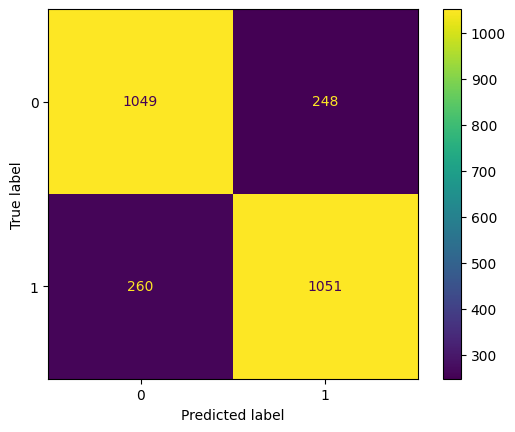

In [307]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

# Submission

In [308]:
test_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,0.0,1.0,1.0,0.341772,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.159513,0.857143,1.0
1,0.0,0.0,1.0,0.240506,0.0,0.000000,0.000356,0.00000,0.142260,0.000000,0.000540,0.0,0.690255,0.714286,1.0
2,0.5,1.0,0.0,0.392405,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000648,0.0,0.930394,0.285714,1.0
3,0.5,0.0,1.0,0.481013,0.0,0.000000,0.263206,0.00000,0.009121,0.026266,0.000864,0.0,0.151972,0.285714,1.0
4,0.0,0.0,1.0,0.253165,0.0,0.000865,0.000000,0.07658,0.000000,0.000000,0.001079,0.0,0.426914,0.714286,1.0


In [309]:
X_test.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
3369,0.5,0.0,0.0,0.481013,0.0,0.001814,0.115923,0.00000,0.066316,0.047943,0.390236,0.142857,0.448556,0.285714,0.0
6765,1.0,1.0,1.0,0.385002,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.769587,0.285714,0.722473,0.571429,1.0
7320,0.5,0.0,1.0,0.430380,0.0,0.000768,0.110656,0.00000,0.045207,0.000622,0.844056,0.142857,0.854242,0.142857,1.0
6615,0.0,0.0,1.0,0.278481,0.0,0.049696,0.000201,0.00298,0.000000,0.000000,0.752021,0.000000,0.613718,0.571429,0.0
7077,0.5,1.0,0.0,0.189873,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.811510,0.142857,0.010830,0.142857,1.0


In [310]:
# Load the test dataset
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = df_test.PassengerId


predictions = VotingC.predict(test_data)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({"PassangerId": submission_id,
                       "Transported": n_predictions.squeeze()})
output.head()

,PassangerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [311]:
sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = n_predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
